In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Modeling packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import partial_dependence


In [32]:
df = pd.read_csv('../data/cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          10462 non-null  object
 1   source           10462 non-null  object
 2   destination      10462 non-null  object
 3   dep_time         10462 non-null  object
 4   arrival_time     10462 non-null  object
 5   duration         10462 non-null  int64 
 6   total_stops      10462 non-null  int64 
 7   additional_info  10462 non-null  object
 8   price            10462 non-null  int64 
 9   month            10462 non-null  int64 
 10  day              10462 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 899.2+ KB


EDA

Text(0, 0.5, 'Median Price')

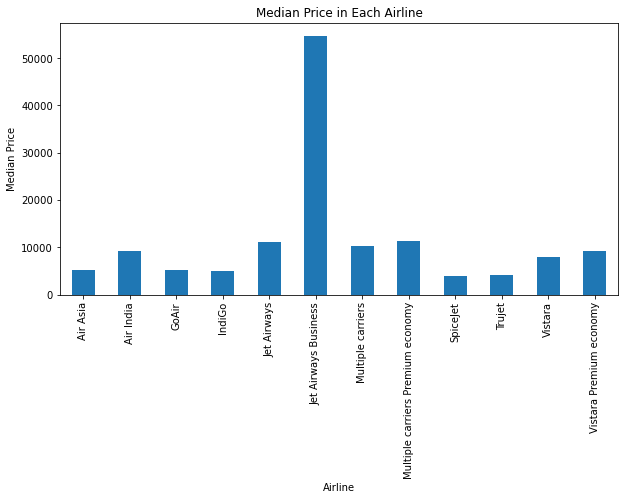

In [33]:
#What's the median price in each airline?

fig = plt.figure(figsize=(10,5))
median_airline_price = df.groupby('airline')['price'].median()
median_airline_price.plot.bar(x = 'airlines', rot=90)
#df.sort_values('airline',inplace=True) << I WANT TO ARRANGE IT IN DESCENDING
plt.title("Median Price in Each Airline")
plt.xlabel("Airline")
plt.ylabel("Median Price")

##Jet Airways Business has the heighest median price, whereas SpiceJet has the lowest.

Text(0, 0.5, 'Median Price')

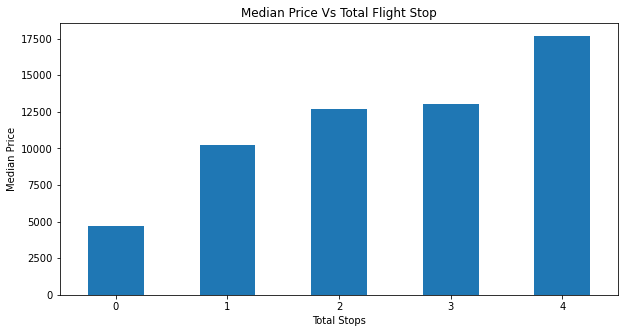

In [34]:
#What's the median price according to the number of total stops between the source and destinatio?

fig = plt.figure(figsize=(10,5))
median_stops_price = df.groupby('total_stops')['price'].median()
median_stops_price.plot.bar(x = 'total_stops', rot=360)
#df.sort_values('airline',inplace=True) << I WANT TO ARRANGE IT IN DESCENDING
plt.title("Median Price Vs Total Flight Stop")
plt.xlabel("Total Stops")
plt.ylabel("Median Price")

##The median price increase as the total stops increase.

Text(0, 0.5, 'Median Price')

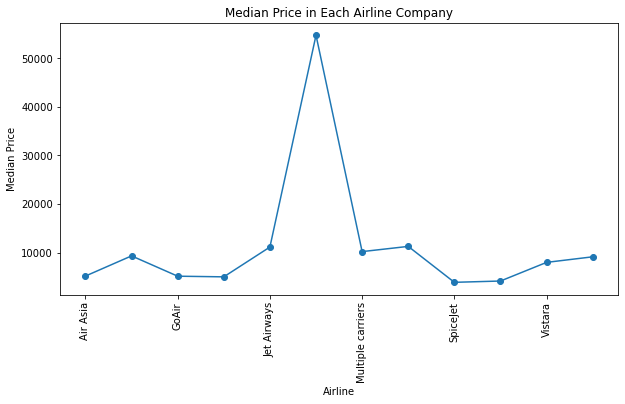

In [35]:
#Median price per airline company
fig = plt.figure(figsize=(10,5))
median_airline_price = df.groupby('airline')['price'].median()
median_airline_price.plot.line(x = 'airline', rot=90, marker='o')
#plt.xticks(df['airline']) << I WANT TO SHOW ALL COMPANIES AT THE X-AXIS!!!!
plt.title("Median Price in Each Airline Company")
plt.xlabel("Airline")
plt.ylabel("Median Price")


Machine Learning (Decision Tress)

In [36]:
# create train/test split
train, test = train_test_split(df, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("price", axis=1)
y_train = train[["price"]]

Full Model

In [37]:
#Decision Tress model object
dt_mod = DecisionTreeRegressor()

#loss function
loss = 'neg_root_mean_squared_error'

# 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# create new feature set with encoded features
X_train_encoded = pd.get_dummies(X_train)

# Create grid of hyperparameter values
hyper_grid = {
  'ccp_alpha': [1e-1, 1e-5, 1e-10],
  'max_depth': [1, 8, 15],
  'min_samples_split': [2, 21, 40]
  }

#Tune the model using grid search
grid_search = GridSearchCV(dt_mod, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)

# Optimal penalty parameter in grid search
print(results.best_estimator_.get_params())

# Best model's cross validated RMSE
print(round(abs(results.best_score_), 2))

{'ccp_alpha': 1e-10, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 21, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
2011.65


Feature Importance

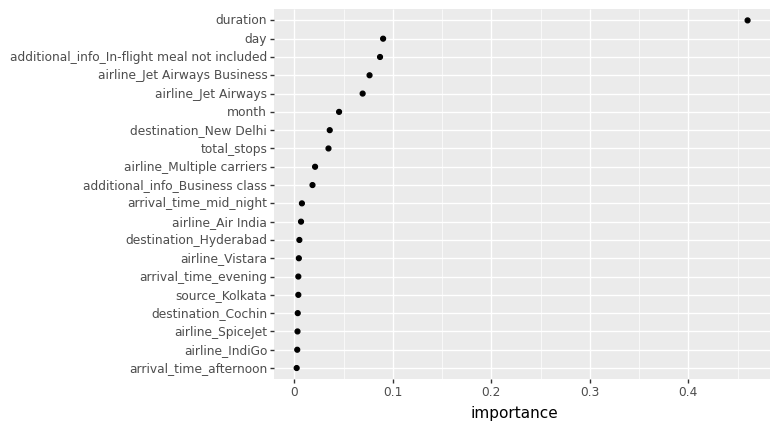

<ggplot: (8763896508275)>

In [38]:
# create final model object
best_mod = results.best_estimator_
best_mod_fit = best_mod.fit(X_train_encoded, y_train)

# extract feature importances
vi = pd.DataFrame({'feature': X_train_encoded.columns,
                   'importance': best_mod_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

Feature Relationship

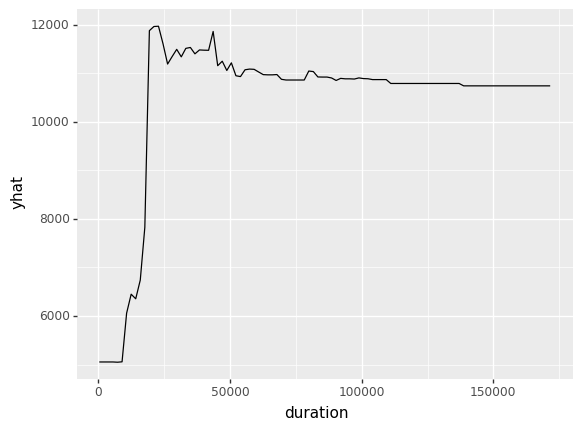

<ggplot: (8763896472727)>

In [39]:
pd_results = partial_dependence(
  best_mod_fit, X_train_encoded, "duration", kind='average',
  percentiles=(0, 1)) 
  
pd_output = pd.DataFrame({'duration': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('duration', 'yhat'))
  + geom_line())
  